Here we give birth to an smarter agent, that takes the last two notes and needs to guess the following one. It uses standard Q-learning (1 step in the future), and its reward is given according to the distance of that note.

In [36]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
    

In [58]:
class Agent():
    def __init__(self, notes_to_choose, target_melody, gamma=0., ep=0.01, index=0, lowest_key=0, reward_distance=True, min_ep=0.01, exploration_phase=10):
        
        
        self.index = index
        
        k=0
        self.ind_to_state={}
        self.state_to_ind={}
        for i1 in range(notes_to_choose):
            for i2 in range(notes_to_choose):
                state = [i1,i2]
                self.ind_to_state[str(k)] = state
                self.state_to_ind[str(state)] = k
                k+=1
        
        self.n_actions = notes_to_choose
        
        self.q = np.ones((k, notes_to_choose))
        self.n = np.ones((k, notes_to_choose))
        
        self.lowest_key=lowest_key ##this will shift the scale of 12 notes
        
        self.epsilon = ep
        self.min_ep = min_ep
        self.gamma = gamma
        self.reward_distance=reward_distance
        self.exploration_phase = exploration_phase
            
        self.qtables_history=[]
        self.reward_history=[]
        self.reward_greedy_history=[]

        self.target_melody = target_melody
        self.trajectories=[self.target_melody]
        self.trajectories_greedy=[self.target_melody]
    
        self.notes_to_state = lambda melody, ind1, ind2: [melody[ind1], melody[ind2]]

        self.peaked_reward = 1
        self.lr_min = 1
        np.random.seed(self.index)
        
    def give_action(self, state, greedy=False):
        if np.random.random()<self.epsilon and (greedy == False):
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[state,:]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]

    def get_reward(self, guess, label):
        if self.reward_distance is True:
            d = np.abs(guess-label)
            return np.exp(-self.peaked_reward*d/self.n_actions)
        else:
            if guess == label:
                return 1
            else:
                return 0
            
    def reset(self):
        self.n = np.ones(self.n.shape)
        
    def get_interesting_q(self):
        interesting_q=[]
        q=self.q.copy()
        for k in q:
            if np.std(k)<0.01:
                pass
            else:
                interesting_q.append(k)
        return np.array(interesting_q)
    
    def q_learn(self, ts):
        self.qtables_history.append(self.get_interesting_q())
        for interaction in ts:
            s, a, r, ns = interaction
            self.reward_history.append(r)
            self.n[s,a]+=1
            lr=np.clip(1/self.n[s,a],0,self.lr_min)
            
            td_target =  r + np.clip(np.max(self.q[ns,:]) , 0, self.gamma)
            self.q[s,a] += (td_target- self.q[s,a])*lr
        
    def decrease_ep(self,ind, tau=100):
        if ind < self.exploration_phase:
            self.epsilon = 1
        else:
            self.epsilon = 0.01
        #self.epsilon = max(self.epsilon*np.exp(-(ind+1)/tau), self.min_ep)
        if ind>50:
            self.reward_distance=False
        return
    
    def give_melody(self, melody):
        note_player=[]
        for ind,note in enumerate(melody):
            note_player.append(self.give_action(note, greedy=True))
        return note_player
    
    def learn_melody(self,N=50):
        
        melody = list(np.array(self.target_melody)-self.lowest_key) ### this is in case the melody exit the octave
        for episode in tqdm(range(N)):
            ts=[]
            trajectory=[]
            greedy_actions=[]
            indM=-2
            state = self.notes_to_state(melody, indM, indM+1)
            state_id = self.state_to_ind[str(state)]
            for target_note in melody:
                action = self.give_action(state_id)
               
                trajectory.append(action)
                
                reward = self.get_reward(target_note, action)
                
                ## gredy action
                greedy_action=self.give_action(state_id,greedy=True)
                greedy_actions.append(greedy_action)
                self.reward_greedy_history.append(self.get_reward(target_note , greedy_action ))
                
                indM+=1
                next_state = self.notes_to_state(melody, indM, indM+1)
                next_state_id = self.state_to_ind[str(next_state)]
                ts.append([state_id, action, reward, next_state_id])
                state_id = next_state_id
            
            self.q_learn(ts)
            self.decrease_ep(episode)
            self.trajectories.append(np.array(trajectory) + self.lowest_key)
            self.trajectories_greedy.append(np.array(greedy_actions) + self.lowest_key)
    def get_cumulative(self, lista):
        return np.cumsum(lista)/np.arange(1,len(lista)+1)
    
    def get_learning_curve(self):
        plt.figure(figsize=(10,10))
        plt.title("Learning curve\ntarget melody: {} \nfinal melody played {}\nfavorite melody {}".format(self.target_melody, self.trajectories[-1], self.trajectories_greedy[-1]), size=20)
        plt.plot(self.get_cumulative(self.reward_history), linewidth=15, alpha=0.7,color="red")
        plt.plot(range(1,len(self.reward_greedy_history)+1), self.reward_greedy_history, linewidth=1, alpha=0.7,color="blue")
        
        plt.xlabel("Episodes",size=30)
        plt.ylabel("Cumulative rewards", size=30)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.ylim([0,1.1])

## Q-learning + reward-distance

How long till you get the correct sequence? Note that rewarding w/ distance not always result in exactly the correct melody (which can be undesirable).

100%|██████████| 100/100 [00:00<00:00, 192.32it/s]


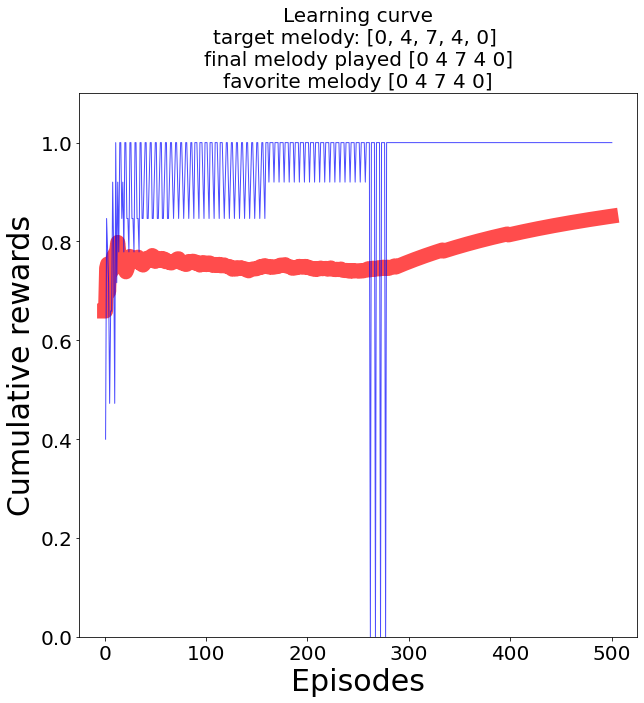

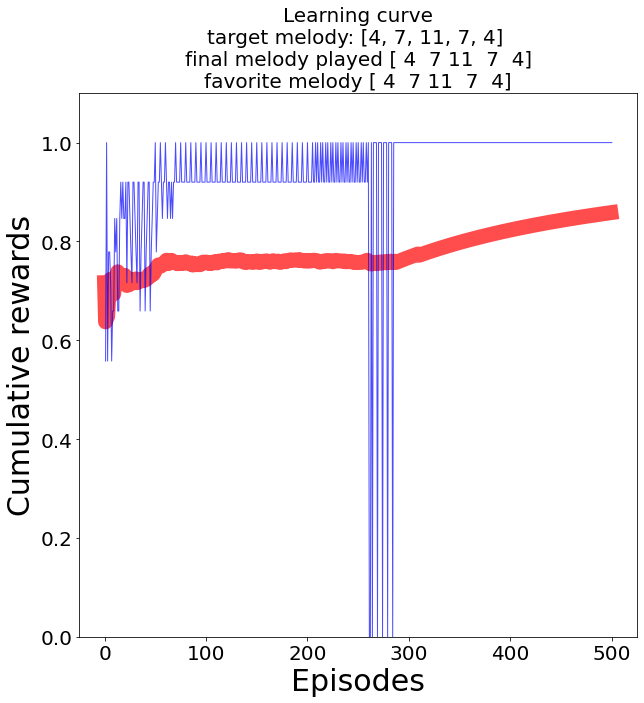

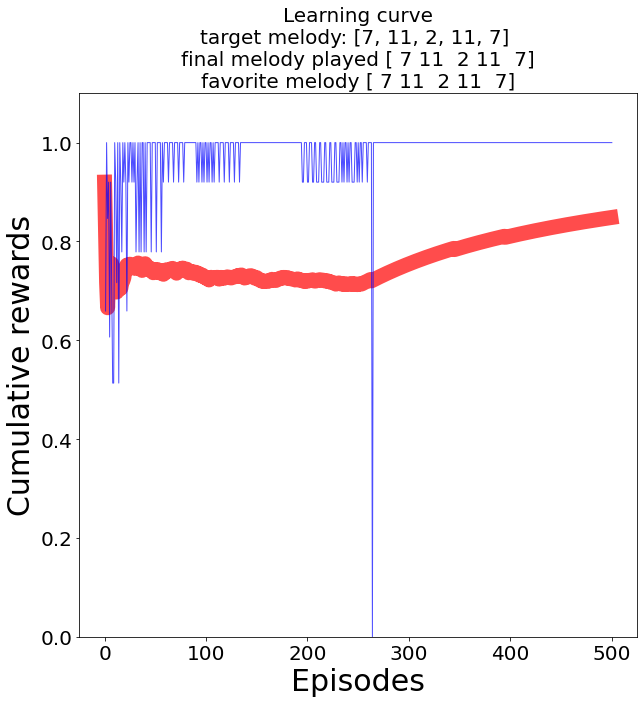

In [59]:
agents = {}

number_of_melodies=100
melodies={}

melodies[0] = [0,4,7,4,0]
melodies[1] = [4,7,11,7,4]
melodies[2] = list(np.array([7,11,14,11,7])%12)
for k in range(3):
    agents[k] = Agent(12, target_melody = melodies[k], ep=1, gamma=1, reward_distance=True, index=k, exploration_phase=50) #,lowest_key=major[k],)
    agents[k].learn_melody(N=number_of_melodies)
    agents[k].get_learning_curve()

## Now let's save the learning curves!

In [60]:
for agent in agents.values():
    os.makedirs("AIdata/agent{}/".format(agent.index), exist_ok=True)
    os.system("rm -r AIdata/agent{}/*".format(agent.index))
    
    for ind, traj in enumerate(agent.trajectories):
        np.savetxt("AIdata/agent{}/played_episode_{}.csv".format(agent.index, ind),np.array([traj]).astype(int), fmt='%i', delimiter=",")
        np.savetxt("AIdata/agent{}/greedy_episode_{}.csv".format(agent.index, ind),np.array([agent.trajectories_greedy[ind]]).astype(int), fmt='%i', delimiter=",")      

## Now we ask the robots to swap roles!

In [61]:
low_keys = [agents[k].lowest_key for k in range(len(agents))]

for swap_melody in range(2):
    
    target_melodies = [agents[k].target_melody for k in range(len(agents))]   ##save target melodies
    number_of_melodies=100
    
    
    for k in range(3):
        agents[k].reset()
        agents[k].target_melody = target_melodies[(k+1)%len(agents)] ## change target melody
        agents[k].learn_melody(N=number_of_melodies)  
        
for k in range(3):
    agents[k].get_learning_curve()

100%|██████████| 100/100 [00:00<00:00, 224.65it/s]


Let's save again the data!

In [65]:
for agent in agents.values():
    os.makedirs("AIdata/agent{}/".format(agent.index), exist_ok=True)
    os.system("rm -r AIdata/agent{}/*".format(agent.index))
    
    for ind, traj in enumerate(agent.trajectories):
        np.savetxt("AIdata/agent{}/played_episode_{}.csv".format(agent.index, ind),np.array([traj]).astype(int), fmt='%i', delimiter=",")
        np.savetxt("AIdata/agent{}/greedy_episode_{}.csv".format(agent.index, ind),np.array([agent.trajectories_greedy[ind]]).astype(int), fmt='%i', delimiter=",")      

### Now let's see what happens if instead of swapping the targets, each robots "copies" the final melody played by the other.

In [77]:
agents = {}

number_of_melodies=100
melodies={}

melodies[0] = [0,4,7,4,0]
melodies[1] = [4,7,11,7,4]
melodies[2] = list(np.array([7,11,14,11,7])%12)
for k in range(3):
    agents[k] = Agent(12, target_melody = melodies[k], ep=1, gamma=1, reward_distance=True, index=k, exploration_phase=50) #,lowest_key=major[k],)
    agents[k].learn_melody(N=100)


for swap_imperfect_melody in range(10):             
    target_melodies = [agents[k].trajectories[-1] for k in range(len(agents))]   ##save target melodies
    
    number_of_melodies=50

    for k in range(3):
        agents[k].reset()
        agents[k].exploration_phase = 15
        agents[k].target_melody = target_melodies[(k+1)%len(agents)] ## change target melody
        agents[k].learn_melody(N=number_of_melodies)  
        


100%|██████████| 50/50 [00:00<00:00, 225.55it/s]


In [78]:
for agent in agents.values():
    os.makedirs("AIdata/agent{}/".format(agent.index), exist_ok=True)
    os.system("rm -r AIdata/agent{}/*".format(agent.index))
    
    for ind, traj in enumerate(agent.trajectories):
        np.savetxt("AIdata/agent{}/played_episode_{}.csv".format(agent.index, ind),np.array([traj]).astype(int), fmt='%i', delimiter=",")
        np.savetxt("AIdata/agent{}/greedy_episode_{}.csv".format(agent.index, ind),np.array([agent.trajectories_greedy[ind]]).astype(int), fmt='%i', delimiter=",")      

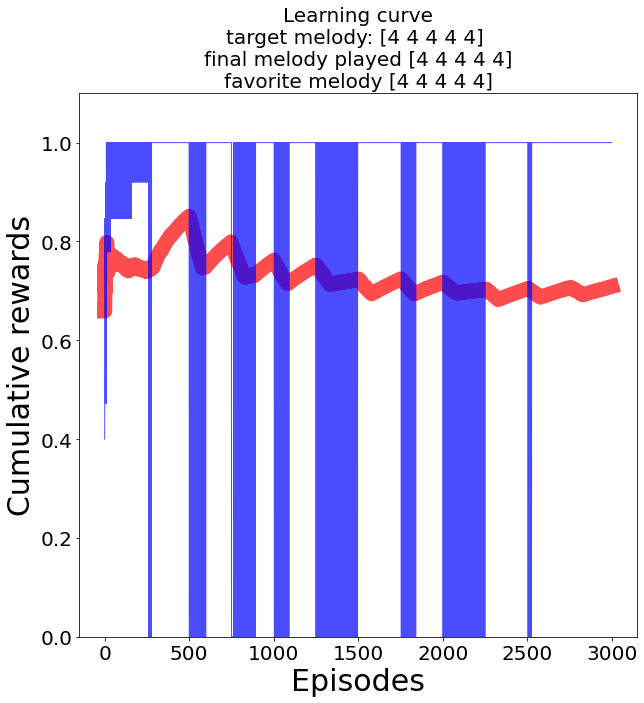

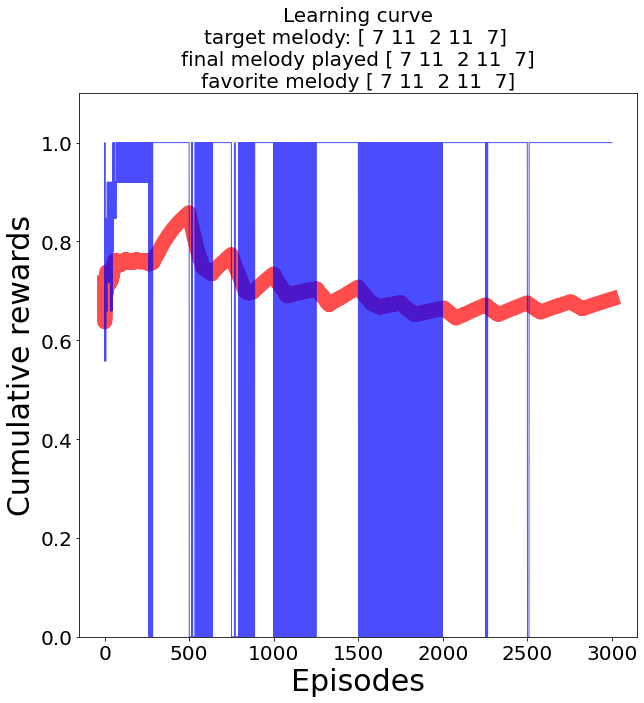

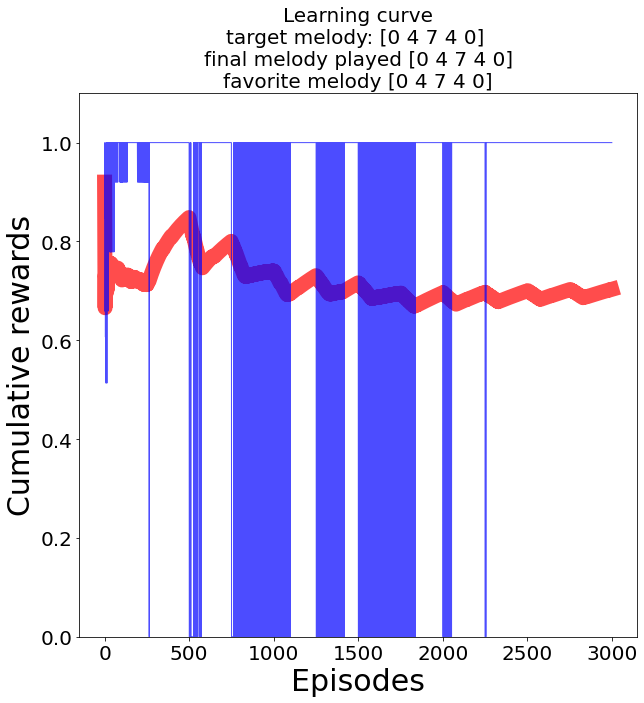

In [79]:
for k in range(3):
    agents[k].get_learning_curve()